In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import milp, LinearConstraint, Bounds
import pulp

In [70]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [71]:
def get_fixtures_df():
    url = "https://fantasy.premierleague.com/api/fixtures/"
    return pd.DataFrame(requests.get(url).json())

fixtures_df = get_fixtures_df()


In [72]:
fpl_data = get_fpl_data()

In [73]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [74]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [75]:
def get_next_gw(gw):
    ev = pd.DataFrame(gw)[["id", "is_next", "is_current", "finished"]].copy()
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    if (ev["finished"] == False).any():
        return int(ev.loc[ev["finished"] == False, "id"].min())
    return int(ev["id"].max())

def team_event_fdr(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum"),
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

In [76]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    return pd.concat([home, away], ignore_index=True)

fx_long = fixtures_long_fdr(fixtures_df)


In [77]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [78]:
print(players_data[1]['chance_of_playing_this_round'])
players_data[0].keys()

None


dict_keys(['can_transact', 'can_select', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'removed', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'region', 'team_join_date', 'birth_date', 'has_temporary_code', 'opta_code', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defen

In [79]:
players_data_df = pd.DataFrame(players_data)

In [80]:
players_data_df = players_data_df[['now_cost','total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes','web_name', 'team', 'chance_of_playing_this_round']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping)


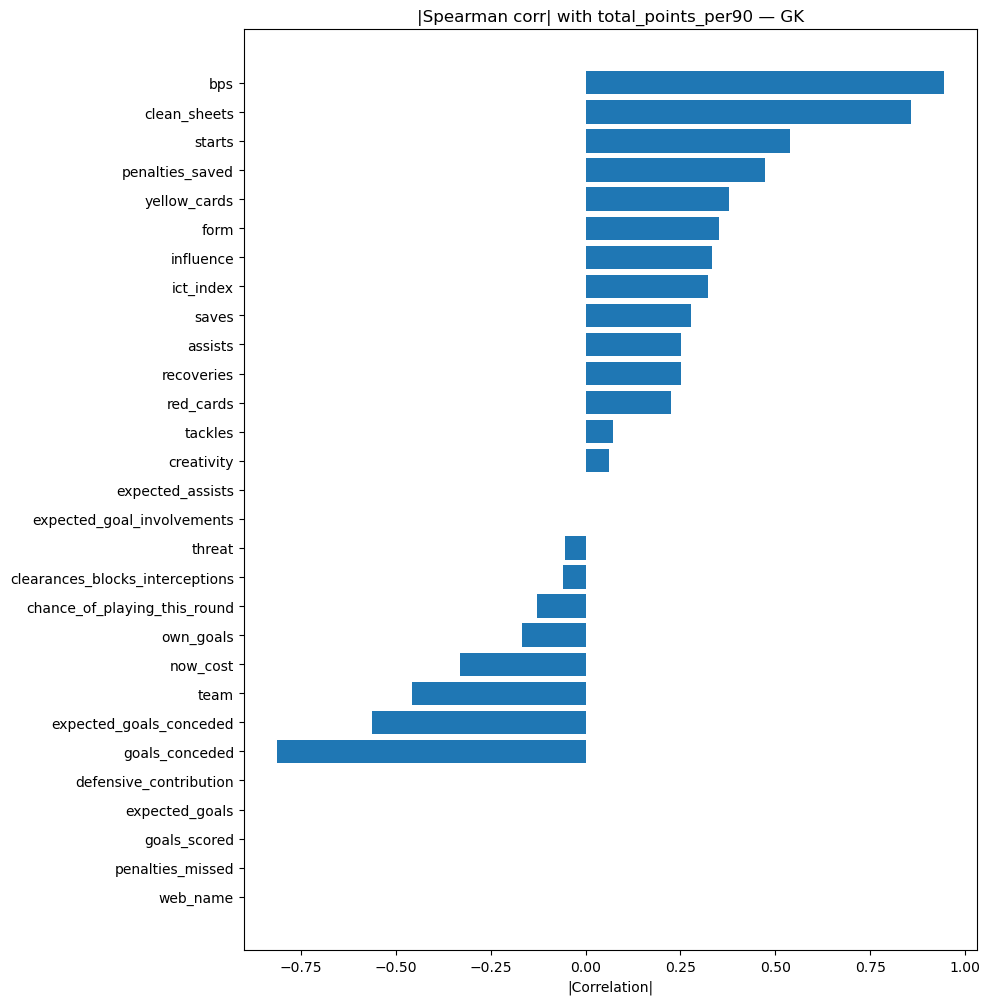

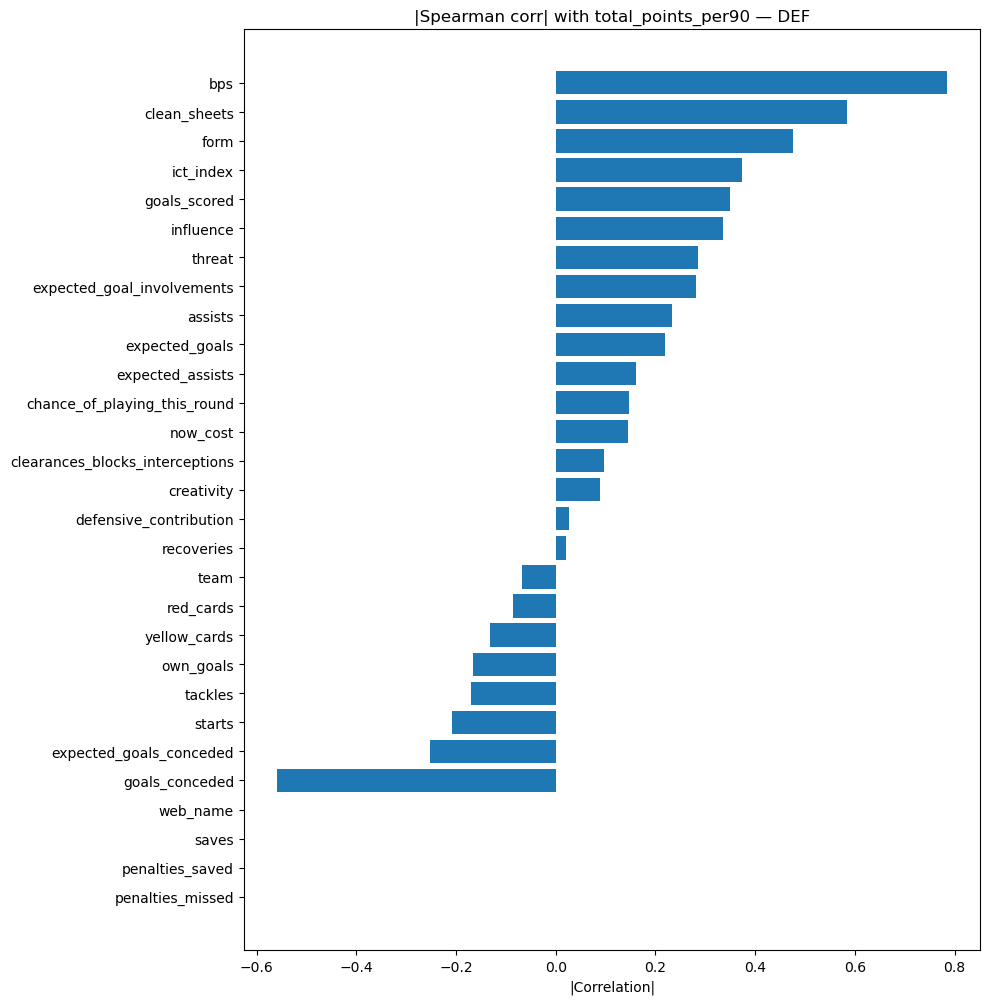

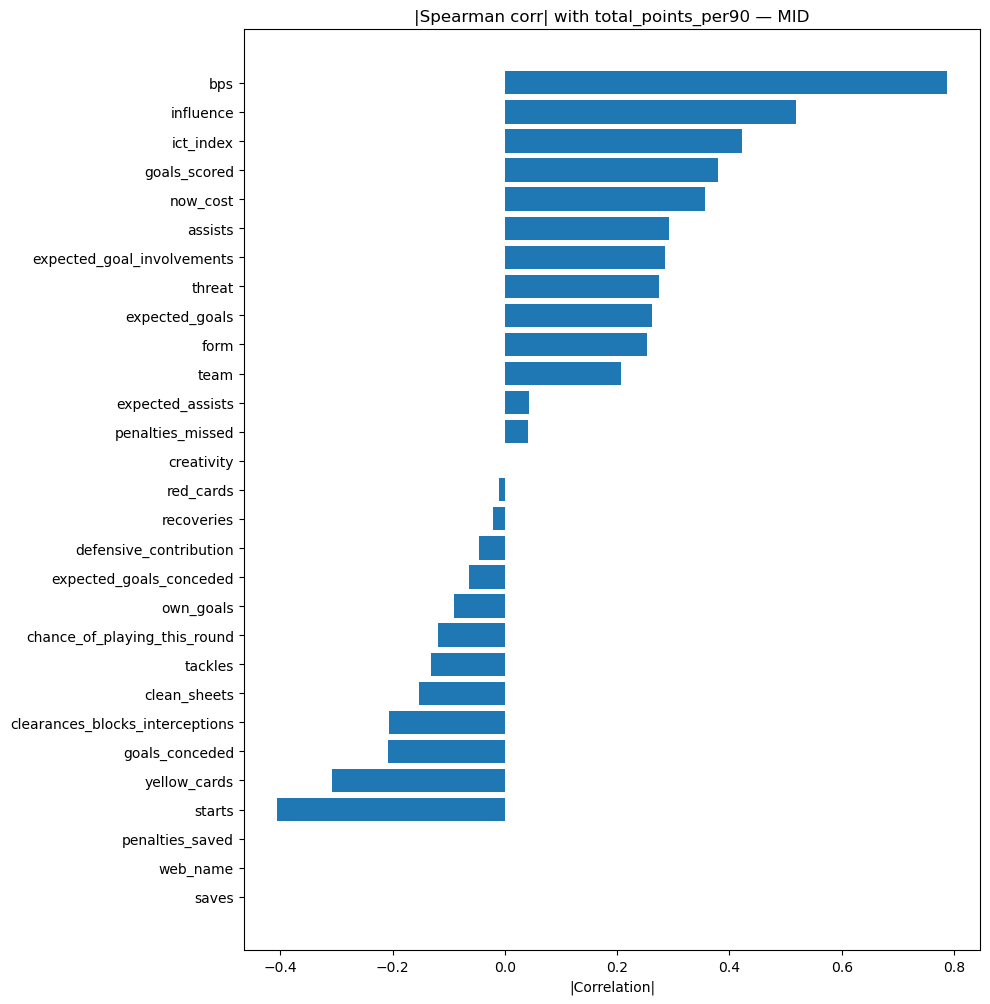

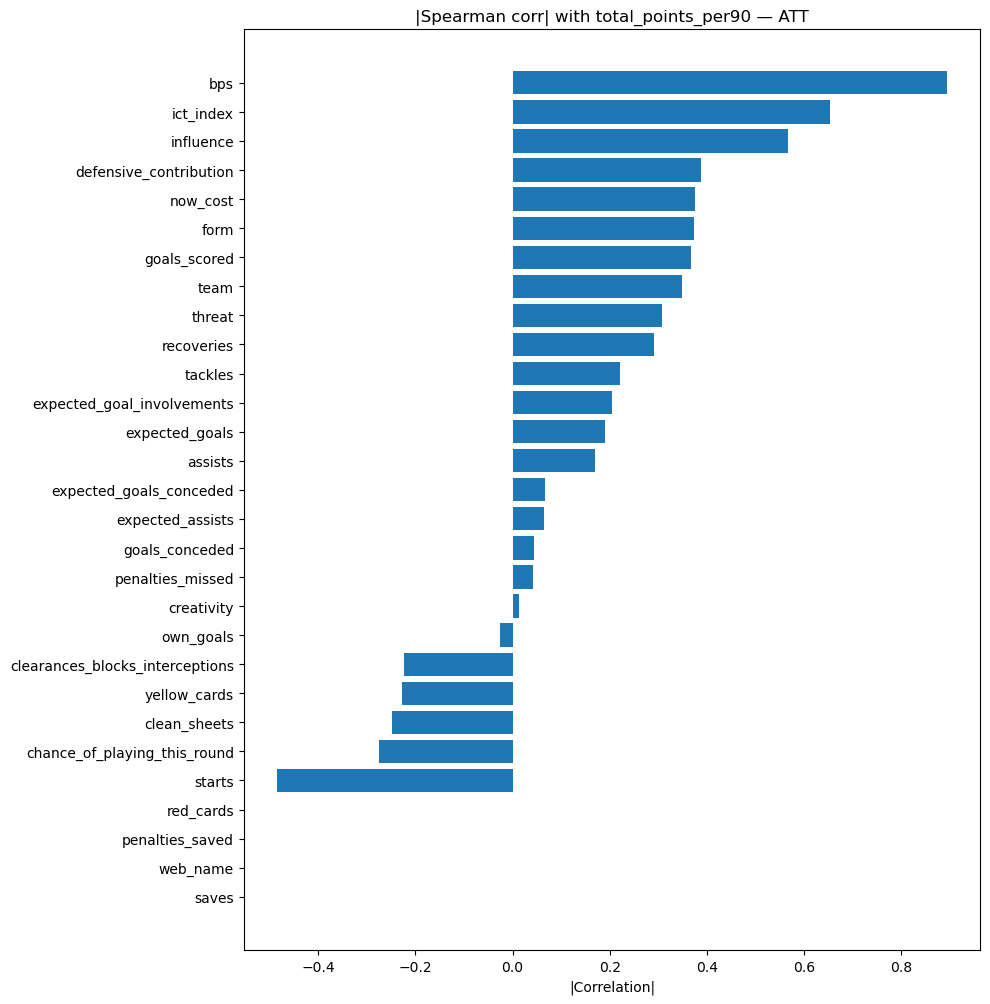

In [81]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]
    

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features)
    
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)


## Data Refresh & Player Metadata Extraction

This section refreshes the FPL API data and extracts key player information for the upcoming gameweek predictions. We retrieve fresh player metadata including ID, name, position, team, cost, and injury status.

In [ ]:
"""
Fetch fresh FPL API data and fixtures for the current season.
- get_bootstrap() retrieves comprehensive player stats, team info, and events from the FPL API
- get_fixtures_df() retrieves all scheduled fixtures with difficulty ratings (FDR) for each team
- These functions ensure we're working with the latest data for predictions
"""

def get_bootstrap():
    """Fetch the FPL bootstrap API endpoint with static data about players, teams, and gameweeks."""
    return requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()

def get_fixtures_df():
    """Fetch FPL fixtures data and return as DataFrame for easier manipulation."""
    return pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/fixtures/").json())

# Refresh API data
fpl_data = get_bootstrap()
fixtures_df = get_fixtures_df()

# Extract key datasets from FPL API response
players_data = fpl_data["elements"]      # All player information
events_data = fpl_data["events"]         # All gameweek events and their status

In [ ]:
"""
Extract core player metadata for optimization model.
This creates a clean reference table with essential player information needed for team selection.
"""

players_meta_df = pd.DataFrame(players_data)[
    ["id","web_name","element_type","team","now_cost","chance_of_playing_this_round"]
].copy()

# Ensure proper data types for downstream computations
players_meta_df["id"] = pd.to_numeric(players_meta_df["id"], errors="coerce").astype(int)
players_meta_df["element_type"] = pd.to_numeric(players_meta_df["element_type"], errors="coerce").astype(int)
players_meta_df["team"] = pd.to_numeric(players_meta_df["team"], errors="coerce").astype(int)
players_meta_df["now_cost"] = pd.to_numeric(players_meta_df["now_cost"], errors="coerce")
players_meta_df["chance_of_playing_this_round"] = pd.to_numeric(players_meta_df["chance_of_playing_this_round"], errors="coerce").fillna(100)

In [ ]:
"""
Reformat fixtures data into long format with FDR (Fixture Difficulty Rating).
This pivots fixture data so each team-gameweek pair has one row with their FDR.
FDR ranges from 1 (easiest) to 5 (hardest) as assigned by FPL.
"""

def fixtures_long_fdr(fixtures_df):
    """
    Convert fixtures into long format with one row per team-fixture combination.
    Separates home and away fixtures for accurate difficulty assessment.
    """
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    # Home team perspective
    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    
    # Away team perspective
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    
    return pd.concat([home, away], ignore_index=True)

# Create long-format fixture data with FDR for all team-gameweek combinations
fx_long = fixtures_long_fdr(fixtures_df)

In [ ]:
"""
Build historical gameweek performance data for each player.
This retrieves the complete performance history for model training, including:
- Individual match statistics (goals, assists, clean sheets, etc.)
- Fixture difficulty ratings (FDR) for context
- Points earned per gameweek
- Value at the time of play
"""

def get_element_summary(player_id):
    """Fetch detailed history for a specific player from the FPL API."""
    url = f"https://fantasy.premierleague.com/api/element-summary/{player_id}/"
    return requests.get(url).json()

def build_player_gw_history(players_meta_df, fx_long):
    """
    Construct a historical dataset of player performances across all gameweeks.
    Merges individual player stats with fixture difficulty ratings.
    """
    rows = []
    # Fetch history for each player
    for pid in players_meta_df["id"].tolist():
        j = get_element_summary(int(pid))
        h = pd.DataFrame(j.get("history", []))
        if len(h) == 0:
            continue
        h["id"] = int(pid)
        rows.append(h)

    hist = pd.concat(rows, ignore_index=True)

    # Select relevant performance columns
    keep = [
        "id","round","opponent_team","was_home","total_points","minutes",
        "goals_scored","assists","clean_sheets","goals_conceded","saves",
        "penalties_saved","penalties_missed","yellow_cards","red_cards",
        "influence","creativity","threat","ict_index",
        "expected_goals","expected_assists","expected_goals_conceded",
        "value"
    ]
    keep = [c for c in keep if c in hist.columns]
    hist = hist[keep].copy()

    # Ensure proper data types
    hist["id"] = pd.to_numeric(hist["id"], errors="coerce").astype(int)

    # Merge with player metadata
    hist = hist.merge(
        players_meta_df[["id","web_name","element_type","team"]],
        on="id",
        how="left"
    )

    # Convert all numeric columns
    hist["round"] = pd.to_numeric(hist["round"], errors="coerce").astype(int)
    hist["team"] = pd.to_numeric(hist["team"], errors="coerce").astype(int)
    hist["opponent_team"] = pd.to_numeric(hist["opponent_team"], errors="coerce").astype(int)
    hist["was_home"] = pd.to_numeric(hist["was_home"], errors="coerce").astype(int)

    # Merge with fixture difficulty ratings
    hist = hist.merge(
        fx_long,
        left_on=["round","team","opponent_team","was_home"],
        right_on=["event","team","opponent_team","was_home"],
        how="left"
    ).drop(columns=["event"])

    # Standardize column names and fill missing FDR values
    hist = hist.rename(columns={"total_points":"gw_points", "value":"now_cost"})
    hist["fdr"] = pd.to_numeric(hist["fdr"], errors="coerce").fillna(3.0)
    hist["now_cost"] = pd.to_numeric(hist["now_cost"], errors="coerce")

    return hist

# Build the complete historical dataset
player_gw_df = build_player_gw_history(players_meta_df, fx_long)

In [ ]:
"""
Add rolling window features for time-series modeling.
This creates lagged performance metrics that capture recent form:
- 5-gameweek rolling averages for key performance indicators
- Shifted by 1 gameweek to prevent target leakage (only historical data)
- Includes minutes, goals, assists, expected metrics, and creativity stats
"""

def add_rolling_features(df, group_col="id", time_col="round", windows=(5,), shift=1, cols=None):
    """
    Compute rolling window statistics for each player grouped by time.
    
    Parameters:
    - df: DataFrame with player performance data
    - group_col: Column to group by (player ID)
    - time_col: Column representing time sequence (gameweek round)
    - windows: Tuple of window sizes for rolling averages
    - shift: Number of periods to shift for preventing data leakage
    - cols: List of columns to compute rolling stats for
    
    Returns:
    - DataFrame with original data plus new rolling feature columns (e.g., 'minutes_r5')
    """
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors="coerce")
    d = d.sort_values([group_col, time_col])

    if cols is None:
        cols = [
            "minutes","goals_scored","assists","clean_sheets","goals_conceded","saves",
            "expected_goals","expected_assists","expected_goals_conceded",
            "influence","creativity","threat","ict_index"
        ]
    cols = [c for c in cols if c in d.columns]

    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    # Compute rolling averages for each window size
    for w in windows:
        rolled = d.groupby(group_col, sort=False)[cols].rolling(w, min_periods=1).mean()
        if shift:
            rolled = rolled.shift(shift)
        rolled = rolled.reset_index(level=0, drop=True)
        rolled.columns = [f"{c}_r{w}" for c in cols]
        d = pd.concat([d, rolled], axis=1)

    return d

# Build training dataset with 5-gameweek rolling features (shifted to prevent leakage)
train_df = add_rolling_features(player_gw_df, windows=(5,), shift=1)

In [ ]:
"""
Identify the current/target gameweek for predictions.
Determines which gameweek we're predicting for based on FPL event status:
- is_current: Gameweek currently in progress
- is_next: Next upcoming gameweek
This ensures predictions are made for the correct upcoming gameweek.
"""

def get_current_gw(events):
    """
    Determine the target gameweek to predict for.
    Logic:
    1. If a gameweek is currently active, next prediction is for current + 1
    2. If a gameweek is marked as next, predict for that gameweek
    3. Otherwise, predict for the latest incomplete gameweek
    """
    ev = pd.DataFrame(events)
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0])
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0]) - 1
    return int(ev["id"].max())

# Set the target gameweek for predictions
target_gw = get_current_gw(events_data)

In [ ]:
"""
Define position-specific feature sets and train XGBoost models.
Different player positions require different predictive features:
- GK (1): Focus on defensive metrics and clean sheets
- DEF (2): Balance of defensive and expected metrics
- MID (3): Balanced offensive/defensive with creativity and threat
- FWD (4): Emphasis on offensive metrics and threat

Each position gets its own trained XGBoost model for accurate predictions.
"""

# Map position IDs to their optimal feature sets for point prediction
feature_map_gw = {
    1: ["now_cost","fdr","clean_sheets_r5","goals_conceded_r5","saves_r5","expected_goals_conceded_r5","minutes_r5"],
    2: ["now_cost","fdr","clean_sheets_r5","goals_conceded_r5","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","expected_goals_conceded_r5","minutes_r5"],
    3: ["now_cost","fdr","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","creativity_r5","threat_r5","influence_r5","minutes_r5"],
    4: ["now_cost","fdr","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","threat_r5","influence_r5","minutes_r5"]
}

def fit_predict_by_position(df, feature_map, target="gw_points", pos_col="element_type", pred_col="xgb_pred", params=None):
    """
    Train separate XGBoost models for each player position.
    
    Parameters:
    - df: Historical training data
    - feature_map: Dictionary mapping position IDs to feature lists
    - target: Target column name (points earned)
    - pos_col: Column containing position information
    - pred_col: Output column name for predictions
    - params: Optional parameter overrides for XGBoost
    
    Returns:
    - df with new predictions column
    - Dictionary of trained models keyed by position
    """
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")
    d[pred_col] = np.nan

    # XGBoost hyperparameters tuned for FPL prediction
    base_params = dict(
        n_estimators=800,          # Number of boosting rounds
        learning_rate=0.03,        # Lower learning rate for stability
        max_depth=4,               # Shallow trees to prevent overfitting
        subsample=0.8,             # Use 80% of samples per tree
        colsample_bytree=0.8,      # Use 80% of features per tree
        reg_lambda=1.0,            # L2 regularization
        objective="reg:squarederror",
        random_state=42
    )
    if params:
        base_params.update(params)

    models = {}
    
    # Train a separate model for each position
    for pos, feats in feature_map.items():
        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        if len(sub) < 2:
            continue

        for c in feats:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")

        sub = sub.dropna(subset=[target])
        if len(sub) < 2:
            continue

        X = sub[feats].fillna(0)
        y = sub[target].to_numpy()

        # Use train-test split if enough data, otherwise train on all
        if len(sub) < 20:
            model = XGBRegressor(**base_params)
            model.fit(X, y, verbose=False)
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
            model = XGBRegressor(**base_params)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = model
        d.loc[sub.index, pred_col] = model.predict(X)

    return d, models

In [ ]:
"""
Train position-specific XGBoost models on historical data.
Using all gameweeks before target gameweek to train models that predict
expected points for the upcoming gameweek.
"""

# Filter training data to only include gameweeks before the target gameweek
train_cut = train_df.loc[train_df["round"] < target_gw].copy()

# Train models for each position and generate predictions on training data
train_cut_with_preds, models = fit_predict_by_position(
    train_cut,
    feature_map_gw,
    target="gw_points",
    pos_col="element_type",
    pred_col="xgb_pred"
)

# Display the enhanced training dataset with predictions
train_cut_with_preds

,id,round,opponent_team,was_home,gw_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,goals_conceded_r5,saves_r5,expected_goals_r5,expected_assists_r5,expected_goals_conceded_r5,influence_r5,creativity_r5,threat_r5,ict_index_r5,xgb_pred
0,1,1,14,0,10,90,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.481792
1,1,2,11,1,6,90,0,0,1,0,...,0.000000,7.000000,0.0,0.000000,1.520000,49.200000,0.000000,0.0,4.900000,5.740212
2,1,3,12,0,2,90,0,0,0,1,...,0.000000,4.000000,0.0,0.000000,0.845000,31.300000,0.000000,0.0,3.100000,2.409529
3,1,4,16,1,6,90,0,0,1,0,...,0.333333,3.333333,0.0,0.006667,0.736667,27.533333,3.333333,0.0,3.066667,5.841411
4,1,5,13,1,2,90,0,0,0,1,...,0.250000,2.750000,0.0,0.005000,0.602500,23.850000,2.500000,0.0,2.625000,1.570709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,766,17,5,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052579
13390,767,17,5,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.022535
1388,768,17,14,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052579
9298,769,17,2,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.022535


In [ ]:
"""
Define fixture difficulty aggregation functions for future gameweek assessment.
These functions compute team fixture difficulties for the upcoming gameweeks,
helping predict which teams will have easier/harder schedules ahead.
"""

def team_event_fdr(fixtures_df):
    """
    Aggregate FDR by team and gameweek.
    For gameweeks with multiple fixtures, returns average difficulty.
    """
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    # Home fixtures
    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    
    # Away fixtures
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    # Aggregate FDR per team-gameweek
    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum")
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

def build_team_future_fdr(team_event_df, start_gw, horizon=3):
    """
    Calculate upcoming fixture difficulty for a team over a specified horizon.
    
    Parameters:
    - team_event_df: DataFrame of FDR by team and gameweek
    - start_gw: Gameweek to start looking ahead from
    - horizon: Number of gameweeks to project (default 3)
    
    Returns:
    - DataFrame with next gameweek FDR and rolling average FDR for horizon
    """
    # Get FDR for immediate next gameweek
    d1 = team_event_df.loc[team_event_df["event"].eq(start_gw), ["team","fdr","games"]].copy()
    d1 = d1.rename(columns={"fdr":"fdr_1","games":"games_1"})

    # Get average FDR over the horizon
    dh = team_event_df.loc[team_event_df["event"].between(start_gw, start_gw + horizon - 1), ["team","fdr","games"]].copy()
    agg = dh.groupby("team", as_index=False).agg(
        **{
            f"fdr_mean_{horizon}": ("fdr","mean"),
            f"games_{horizon}": ("games","sum"),
        }
    )

    out = agg.merge(d1, on="team", how="left")
    return out

def add_fixture_difficulty_features(players_df, fixtures_df, events_df, team_col="team", start_gw=None, horizon=3, fdr_fill=3.0):
    """
    Add upcoming fixture difficulty metrics to player dataframe.
    Enriches player data with their team's upcoming schedule strength.
    """
    if start_gw is None:
        # Automatically determine start gameweek from events data
        ev = pd.DataFrame(events_df)
        if (ev["is_next"] == True).any():
            start_gw = int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
        elif (ev["is_current"] == True).any():
            start_gw = int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
        else:
            start_gw = int(ev["id"].max())

    te = team_event_fdr(fixtures_df)
    tf = build_team_future_fdr(te, start_gw=start_gw, horizon=horizon)

    # Merge fixture difficulty metrics with player data
    out = players_df.merge(tf, on="team", how="left")

    # Ensure proper types and fill missing values
    out["fdr_1"] = pd.to_numeric(out["fdr_1"], errors="coerce").fillna(fdr_fill)
    out["games_1"] = pd.to_numeric(out["games_1"], errors="coerce").fillna(0).astype(int)
    out[f"fdr_mean_{horizon}"] = pd.to_numeric(out[f"fdr_mean_{horizon}"], errors="coerce").fillna(fdr_fill)
    out[f"games_{horizon}"] = pd.to_numeric(out[f"games_{horizon}"], errors="coerce").fillna(0).astype(int)

    return out

In [ ]:
"""
Build prediction dataframe with current player state and fixture context.
Assembles the latest player statistics, rolling features, costs, injury status,
and upcoming fixture difficulty for the prediction model.
"""

# Get the most recent data for each player before target gameweek
state_df = player_gw_df.loc[player_gw_df["round"] < target_gw].copy()
# Add rolling features without shift to get most current form metrics
state_df = add_rolling_features(state_df, windows=(5,), shift=0)

# Get each player's latest gameweek record
latest_state = state_df.sort_values(["id","round"]).groupby("id", as_index=False).tail(1).copy()

# Select relevant columns: ID, position, team, name + 5-gameweek rolling averages
keep_cols = ["id","element_type","team","web_name"] + [c for c in latest_state.columns if c.endswith("_r5")]
pred_df = latest_state[keep_cols].copy()

# Add current cost and injury probability
pred_df = pred_df.merge(
    players_meta_df[["id","now_cost","chance_of_playing_this_round"]],
    on="id",
    how="left"
)

# Add upcoming fixture difficulty information
pred_df = pred_df.merge(
    add_fixture_difficulty_features(
        players_meta_df[["team"]].drop_duplicates().merge(players_meta_df[["team"]], on="team"),
        fixtures_df,
        pd.DataFrame(events_data),
        start_gw=target_gw,
        horizon=3
    )[["team","fdr_1","games_1","fdr_mean_3","games_3"]].drop_duplicates(),
    on="team",
    how="left"
)

# Ensure proper data types
pred_df["fdr_1"] = pd.to_numeric(pred_df["fdr_1"], errors="coerce").fillna(3.0)
pred_df["games_1"] = pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0).astype(int)
pred_df["chance_of_playing_this_round"] = pd.to_numeric(pred_df["chance_of_playing_this_round"], errors="coerce").fillna(100)

In [ ]:
"""
Generate predictions for the target gameweek.
Uses trained position-specific XGBoost models to predict expected points.
Adjusts predictions by number of upcoming games (not all players play every gameweek).
"""

pred_df = pred_df.copy()

# Add fixture difficulty for model input
pred_df["fdr"] = pred_df["fdr_1"]

# Initialize predictions column
pred_df["xgb_pred"] = np.nan

# Generate predictions for each position using its trained model
for pos, feats in feature_map_gw.items():
    sub = pred_df.loc[pred_df["element_type"].eq(pos)]
    if len(sub):
        # Predict expected points per gameweek
        pred_df.loc[sub.index, "xgb_pred"] = models[pos].predict(sub[feats].fillna(0))

# Adjust predictions by number of games in the gameweek
# (accounts for players who might not play all matches)
pred_df["gw_score"] = pred_df["xgb_pred"] * pred_df["games_1"]

In [ ]:
"""
Optimization function to find the best starting 11.
Uses mixed integer linear programming (MILP) to maximize predicted points
while respecting FPL constraints:
- Total budget constraint (typically £100m or £81.5m after fees)
- Positional requirements (1 GK, 3-5 DEF, 3-5 MID, 1-3 FWD)
- Maximum 3 players from same team (prevents concentration risk)
- Availability constraint (exclude injured/unavailable players)
"""

def pick_starting_xi(
    df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    budget=81.5,
    pos_limits={1: (1, 1), 2: (3, 5), 3: (3, 5), 4: (1, 3)},
    max_from_team=3,
):
    """
    Solve constrained optimization problem to find optimal team selection.
    
    Parameters:
    - df: Player dataframe with predictions and metadata
    - points_col: Column with expected gameweek points
    - cost_col: Column with player cost in millions
    - pos_col: Column with player position (1=GK, 2=DEF, 3=MID, 4=FWD)
    - team_col: Column with team ID
    - chance_col: Column with probability of playing (%)
    - budget: Total budget available in millions (FPL default is 100m, fees reduce it)
    - pos_limits: Dict mapping position to (min, max) allowed players
    - max_from_team: Maximum players from single team
    
    Returns:
    - Tuple of (selected_players_df, total_predicted_points, total_cost_in_gbp)
    """
    d = df.copy()

    # Ensure all numeric columns are properly formatted
    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[chance_col] = pd.to_numeric(d.get(chance_col, 100), errors="coerce").fillna(100)

    # Filter to available players (excluding those with 0% chance of playing)
    d = d.dropna(subset=[points_col, cost_col, pos_col, team_col]).reset_index(drop=True)
    d = d.loc[d[chance_col].gt(0)].reset_index(drop=True)

    if len(d) < 11:
        raise ValueError("Not enough available players after filtering chance_of_playing_this_round > 0.")

    # Determine if costs are in tenths (e.g., £4.5m stored as 45)
    cost_is_tenths = d[cost_col].max() > 25
    costs = d[cost_col].to_numpy(dtype=float)
    B = budget * 10 if cost_is_tenths else float(budget)

    if cost_is_tenths:
        costs = np.round(costs).astype(int)
        B = int(round(B))

    # Objective: maximize points (minimize negative points)
    points = d[points_col].to_numpy(dtype=float)
    n = len(d)
    c = -points
    
    # All variables are binary (player selected or not)
    integrality = np.ones(n, dtype=int)
    bounds = Bounds(0, 1)

    # Build constraint matrix and bounds
    rows = []
    lb = []
    ub = []

    # Constraint 1: Exactly 11 players selected
    rows.append(np.ones(n))
    lb.append(11)
    ub.append(11)

    # Constraint 2: Total cost within budget
    rows.append(costs.astype(float))
    lb.append(-np.inf)
    ub.append(B)

    # Constraint 3: Positional requirements
    pos_arr = d[pos_col].astype(int).to_numpy()
    for pos, (mn, mx) in pos_limits.items():
        mask = (pos_arr == int(pos)).astype(float)
        if mask.sum() == 0:
            raise ValueError(f"No players found for position {pos}.")
        rows.append(mask)
        lb.append(mn)
        ub.append(mx)

    # Constraint 4: Maximum 3 players per team
    team_arr = d[team_col].to_numpy()
    for t in pd.unique(team_arr):
        mask = (team_arr == t).astype(float)
        rows.append(mask)
        lb.append(-np.inf)
        ub.append(max_from_team)

    # Solve the optimization problem
    A = np.vstack(rows)
    constraints = LinearConstraint(A, lb, ub)

    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints)
    if res.status != 0:
        raise RuntimeError(res.message)

    # Extract selected players
    chosen = res.x > 0.5
    xi = d.loc[chosen].copy()

    # Calculate totals
    total_pred = float(xi[points_col].sum())
    total_cost = float(xi[cost_col].sum())
    total_cost_gbp = total_cost / 10 if cost_is_tenths else total_cost

    return xi, total_pred, total_cost_gbp

In [ ]:
"""
Format and display the selected team in a readable format.
Shows the starting XI with positions, costs, predicted points, and fixtures.
Designates the highest-scoring player as captain.
"""

def show_xi_neatly_plain(
    xi,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    name_col="web_name",
    team_col="team",
    gw_col="gw",
    opp_col="opponent_team",
    home_col="was_home",
    team_name_map=None,
):
    """
    Format selected team for display.
    
    Parameters:
    - xi: DataFrame of selected players
    - points_col: Column with expected points
    - cost_col: Column with cost in £m
    - pos_col: Column with position (1=GK, 2=DEF, 3=MID, 4=FWD)
    - name_col: Column with player name
    - team_col: Column with team ID
    - gw_col: Optional column with gameweek
    - opp_col: Optional column with opponent team ID
    - home_col: Optional column indicating if match is home (1) or away (0)
    - team_name_map: Optional dict to map team IDs to team names
    
    Returns:
    - Formatted DataFrame ready for display
    """
    d = xi.copy()

    # Convert cost to GBP (handle both formats: 4.5m and 45 in tenths)
    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d["cost_gbp"] = np.where(d[cost_col] > 25, d[cost_col] / 10, d[cost_col])

    # Map position IDs to position names
    pos_map = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
    d["position"] = pd.to_numeric(d[pos_col], errors="coerce").map(pos_map)

    # Add team names (if mapping provided)
    if team_name_map is not None:
        d["team_name"] = d[team_col].map(team_name_map)
        if opp_col in d.columns:
            d["opp_name"] = d[opp_col].map(team_name_map)
    else:
        d["team_name"] = d[team_col]
        if opp_col in d.columns:
            d["opp_name"] = d[opp_col]

    # Add fixture information (opponent and home/away)
    if opp_col in d.columns:
        ha = ""
        if home_col in d.columns:
            ha = np.where(pd.to_numeric(d[home_col], errors="coerce").fillna(0).astype(int).eq(1), " (H)", " (A)")
        d["fixture"] = d["opp_name"].astype(str) + ha
    else:
        d["fixture"] = ""

    # Designate captain (highest expected points)
    cap_idx = d[points_col].idxmax()
    d["role"] = ""
    d.loc[cap_idx, "role"] = "(C)"

    # Sort by position then by expected points (within position)
    d["pos_order"] = pd.to_numeric(d[pos_col], errors="coerce").map({1:0,2:1,3:2,4:3}).fillna(9).astype(int)

    # Select and format output columns
    cols = ["role", name_col, "position", "team_name"]
    if gw_col in d.columns:
        cols += [gw_col]
    cols += ["fixture", "cost_gbp", points_col]

    out = d.sort_values(["pos_order", points_col], ascending=[True, False])[cols].copy()
    out["cost_gbp"] = out["cost_gbp"].round(1)
    out[points_col] = out[points_col].round(2)
    return out

# Generate and display the recommended starting XI
xi, total_pred, total_cost_gbp = pick_starting_xi(pred_df)
xi_view = show_xi_neatly_plain(xi, points_col="gw_score")
print(xi_view.to_string(index=False))

role      web_name position  team_name fixture  cost_gbp  gw_score
          Petrović       GK          4               4.5      4.89
         Mykolenko      DEF          9               4.9      6.93
             Keane      DEF          9               4.7      6.79
         Tarkowski      DEF          9               5.5      6.56
            Virgil      DEF         12               5.9      6.49
           Ballard      DEF         17               4.7      5.98
          Garnacho      MID          7               6.4      6.80
          E.Le Fée      MID         17               4.9      5.76
            Cherki      MID         13               6.6      5.56
 (C)       Haaland      FWD         13              15.1      9.31
     Calvert-Lewin      FWD         11               5.8      8.97
